In [1]:
import pandas as pd
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
import pyro.ops.stats as stats

import rethinking

"The posterior distribution is a probability distribution.
And like all probability distributions, we can imagine drawing _samples_ from it. The sampled
events in this case are parameter values. Most parameters have no exact empirical realiza-
tion. The Bayesian formalism treats parameter distributions as relative plausibility, not as
any physical random process. In any event, randomness is always a property of informa-
tion, never of the real world. But inside the computer, parameters are just as empirical as
the outcome of a coin flip or a die toss or an agricultural experiment. The posterior defines
the expected frequency that different parameter values will appear, once we start plucking
parameters out of it."

"It is often easier and more intuitive to work with samples from the posterior, than to work with probabilities and integrals directly".

# 3.1

In [2]:
# Compute the posterior for globe tossing moddel with grid approximation
p_grid = torch.linspace(start=0,end=1,steps=1000)
prior = torch.tensor(1.).repeat(1000)
likelihood = dist.Binomial(total_count=9, probs=p_grid).log_prob(torch.tensor(6.)).exp()
posterior = likelihood * prior
posterior = posterior / sum(posterior)

In [3]:
posterior

tensor([2.4130e-42, 8.4336e-19, 5.3813e-17, 6.1112e-16, 3.4234e-15, 1.3020e-14,
        3.8760e-14, 9.7442e-14, 2.1646e-13, 4.3751e-13, 8.2075e-13, 1.4496e-12,
        2.4359e-12, 3.9257e-12, 6.1052e-12, 9.2078e-12, 1.3521e-11, 1.9393e-11,
        2.7244e-11, 3.7569e-11, 5.0951e-11, 6.8070e-11, 8.9711e-11, 1.1677e-10,
        1.5028e-10, 1.9140e-10, 2.4144e-10, 3.0186e-10, 3.7431e-10, 4.6060e-10,
        5.6276e-10, 6.8300e-10, 8.2377e-10, 9.8773e-10, 1.1778e-09, 1.3972e-09,
        1.6494e-09, 1.9380e-09, 2.2672e-09, 2.6414e-09, 3.0651e-09, 3.5434e-09,
        4.0818e-09, 4.6861e-09, 5.3623e-09, 6.1171e-09, 6.9575e-09, 7.8908e-09,
        8.9251e-09, 1.0069e-08, 1.1330e-08, 1.2720e-08, 1.4246e-08, 1.5920e-08,
        1.7753e-08, 1.9757e-08, 2.1943e-08, 2.4324e-08, 2.6913e-08, 2.9725e-08,
        3.2774e-08, 3.6075e-08, 3.9645e-08, 4.3501e-08, 4.7658e-08, 5.2137e-08,
        5.6955e-08, 6.2133e-08, 6.7690e-08, 7.3649e-08, 8.0031e-08, 8.6860e-08,
        9.4158e-08, 1.0195e-07, 1.1027e-

To draw 10000 samples from this posterior, we imagine the posterior as a bucket full of parameter values. Within it, each value exists in proportion to its posterior prob., such that values closer to the peak are more common than those in tails.

We draw 10000 values, and assuming it is well-mixed, the samples should have the same proportion as the exact posterior density.

In [4]:
samples = dist.Empirical(p_grid, posterior.log()).sample(torch.Size([int(1e4)]))

In [5]:
samples

tensor([0.8719, 0.7227, 0.6296,  ..., 0.5485, 0.7257, 0.5175])

_Samples_ has randomly taken values from *p_grid* and the probability of each value is given by *posterior*.

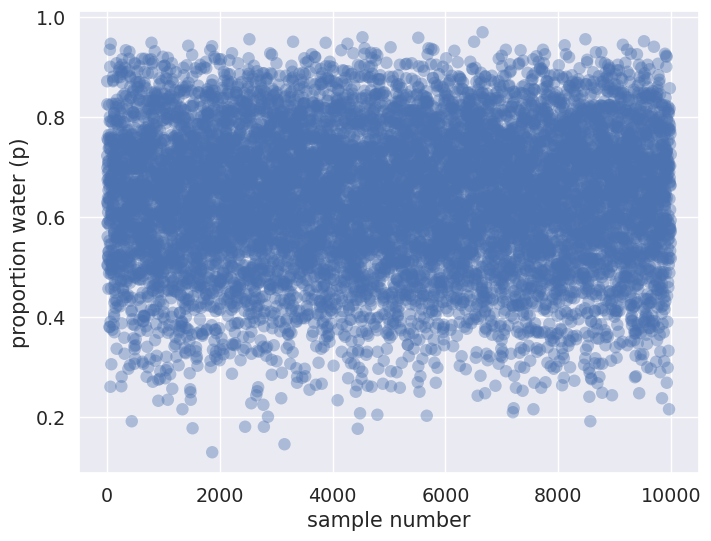

In [6]:
ax = sns.scatterplot(x=range(len(samples)), y=samples, s=80, alpha=0.4, edgecolor="none")
ax.set(xlabel="sample number", ylabel="proportion water (p)");

/tmp/ipykernel_53619/3994540878.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(samples)


[Text(0.5, 0, 'proportion water (p)'), Text(0, 0.5, 'density')]

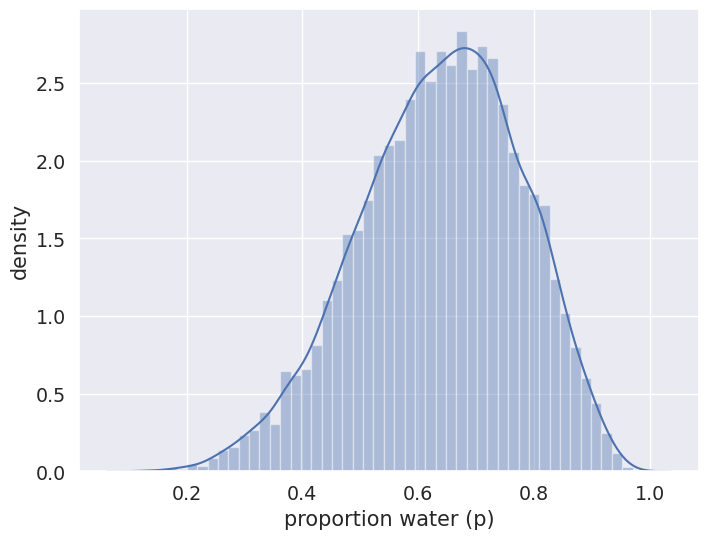

In [7]:
ax = sns.distplot(samples)
ax.set(xlabel='proportion water (p)', ylabel='density')

This estimated density is similar to the (ideal) posterior computed via grid approximation. Quickly checking an even higher number of samples and whether this makes the DE more similar to the ideal one.

/tmp/ipykernel_53619/1406157724.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(samples)


[Text(0.5, 0, 'proportion water (p)'), Text(0, 0.5, 'density')]

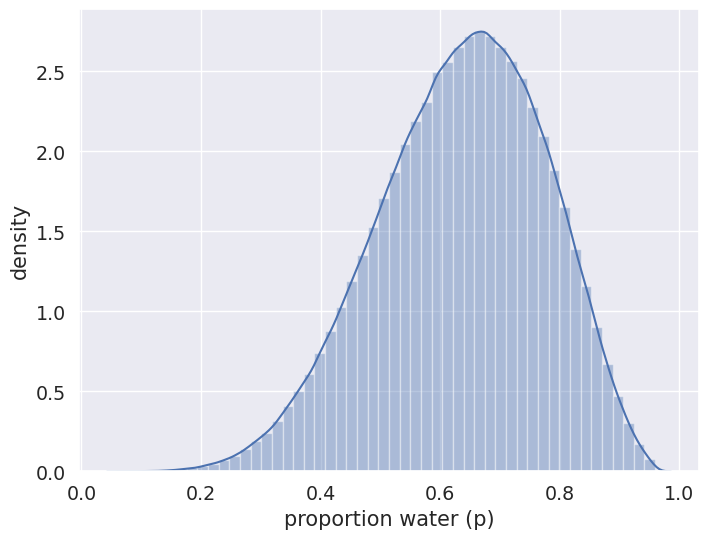

In [8]:
# Compute the posterior for globe tossing moddel with grid approximation
p_grid = torch.linspace(start=0,end=1,steps=int(1e6))
prior = torch.tensor(1.).repeat(int(1e6))
likelihood = dist.Binomial(total_count=9, probs=p_grid).log_prob(torch.tensor(6.)).exp()
posterior = likelihood * prior
posterior = posterior / sum(posterior)
samples = dist.Empirical(p_grid, posterior.log()).sample(torch.Size([int(1e6)]))
ax = sns.distplot(samples)
ax.set(xlabel='proportion water (p)', ylabel='density')

# 3.2

**Intervals of defined boundaries**

In [9]:
# add up posterior probability where p < 0.5
(posterior[p_grid < 0.5]).sum()

tensor(0.1719)

Get the same defined boundary, whilst using samples from the posterior. Here we similarly add up all of the samples below 0.5, but also divide that count by the total number of samples (i.e. the frequency)

In [10]:
(samples < 0.5).sum().float() / 1e6

tensor(0.1725)

In [11]:
# how much posterior probability lies between 0.5 and 0.75
((samples > 0.5) & (samples < 0.75)).sum().float() / 1e6

tensor(0.6042)

**Intervals of defined mass**

In [12]:
# where is the lower 80% posterior probability boundary (at which p=x (proportion water))
stats.quantile(samples, 0.8)

tensor(0.7602)

In [13]:
# where is the posterior probability boundary lower 10% and upper 90%
stats.quantile(samples, [0.1, 0.9])

tensor([0.4479, 0.8118])

Consider the posterior distribution and different intervals (Figure 3.3, Statistical Rethinking). THe posterior is consistent with observing three waters in three tosses and a uniform (flat) prior. It is highly skewed with its maximum value at the boundary of *p = 1*. To compute it through grid approximation:

In [14]:
p_grid = torch.linspace(start=0, end=1, steps=1000)
prior = torch.tensor(1.).repeat(1000)
likelihood = dist.Binomial(total_count=3,
                           probs=p_grid).log_prob(torch.tensor(3.)).exp()
posterior = likelihood * prior
posterior = posterior / posterior.sum()
samples = dist.Empirical(p_grid, posterior.log()).sample(torch.Size([int(1e4)]))

In [15]:
# 50% percentile confidence interval
stats.pi(samples, prob = 0.5)

tensor([0.7077, 0.9309])

This interval assigns equal mass (25%) to both the left and right tail of the interval. However, it does exclude the most probable parameter values near *p=1*. This can thus be misleading because it does not describe the shape of the posterior distribution.

In [16]:
# 50% highest posterior density interval
stats.hpdi(samples, prob=0.5)

tensor([0.8398, 1.0000])

The HDPI is the narrowest interval containing the specific 50% probability mass. Although an infinite number of posterior intervals with the same mass should be possible, the HPDI gets you an interval that best represents the parameter values consistent with the data (i.e. the most dense).

attachment:image.png
<img src=attachment:image.png width="500"/>

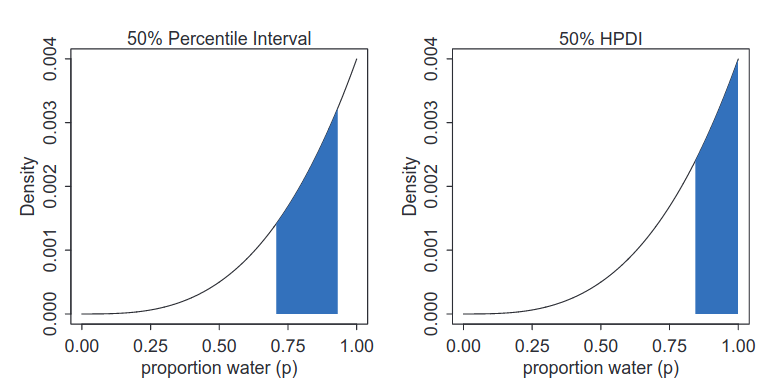

PI and HPDI as different here because the posterior is highly skewed, but in a better balanced distribution, the two types of intervals are very similar (e.g. a Gaussian).

**Point estimates**

In [17]:
# maximum a posteriori (MAP) estimate
p_grid[posterior.argmax()]

tensor(1.)

In [18]:
# MAP for samples from the posterior
adj = 0.01
silverman_factor = (0.75 * samples.size(0)) ** (-0.2)
bandwidth = adj * silverman_factor * samples.std()
x = torch.linspace(samples.min(), samples.max(), 1000)
y = dist.Normal(samples, bandwidth).log_prob(x.unsqueeze(-1)).logsumexp(-1).exp()
x[y.argmax()]

tensor(0.9991)

In [19]:
print(samples.mean())
print(samples.median())

tensor(0.7999)
tensor(0.8398)


**Loss function**

"It turns out that the parameter value that maximizes expected
winnings (minimizes expected loss) is the median of the posterior distribution"

"Calculating expected loss for any given decision means using the posterior to average
over our uncertainty in the true value. Of course we don’t know the true value, in most cases.
But if we are going to use our model’s information about the parameter, that means using the
entire posterior distribution. So suppose we decide *p = 0.5* will be our decision. Then the
expected loss will be:"

In [20]:
(posterior * (0.5 - p_grid).abs()).sum()

tensor(0.3129)

The symbols *posterior* and *p_grid* are the same ones we’ve been using throughout this
chapter, containing the posterior probabilities and the parameter values, respectively. All
the code above does is compute the weighted average loss, where each loss is weighted by its
corresponding posterior probability. There’s a trick for repeating this calculation for every
possible decision

In [21]:
loss = (posterior * (p_grid.unsqueeze(1) - p_grid).abs()).sum(1)
p_grid[loss.argmin()]

tensor(0.8408)

And this is actually the posterior median, the parameter value that splits the posterior density
such that half of the mass is above it and half below it.

# 3.3

Sampling from the posterior is additionally useful for **simulating** a model:

- (1) _Model checking_ after fitting to real data, to check anew with sampled observations and seeing how the model behaves.
- (2) _Software validation_ to simulate observations under a known model and try to recoved parameters the data were simulated under.
- (3) _Research design_ for evaluating it given simulated observations (power analysis)
- (4) _Forecasting_ to simulate new predictions.

"Now note that these assumptions not only allow us to infer the plausibility of each pos-
sible value of p, after observation. That’s what you did in the previous chapter. These as-
sumptions also allow us to simulate the observations that the model implies. They allow this,
because likelihood functions work in both directions. Given a realized observation, the like-
lihood function says how plausible the observation is. And given only the parameters, the
likelihood defines a distribution of possible observations that we can sample from, to simu-
late observation. In this way, Bayesian models are always generative, capable of simulating
predictions"

In [22]:
# suppose n = 2 for tossing and p=0.7 for water, and getting either:
# 0 water, 1 water, 2 water
dist.Binomial(total_count=2, probs=0.7).log_prob(torch.arange(3.)).exp()

tensor([0.0900, 0.4200, 0.4900])

This means that there’s a 9% chance of observing w = 0, a 42% chance of w = 1, and a 49%
chance of w = 2. If you change the value of p, you’ll get a different distribution of implied
observations

Now we’re going to simulate observations, using these likelihoods.

In [23]:
dist.Binomial(total_count=2,probs=0.7).sample().long()

tensor(1)

In [24]:
dist.Binomial(total_count=2,probs=0.7).sample(torch.Size([10])).long()

tensor([1, 2, 2, 2, 1, 2, 2, 1, 1, 2])

Let’s generate 100,000 dummy observations, just to verify that each value (0, 1, or 2) appears
in proportion to its likelihood

In [25]:
dummy_w = dist.Binomial(total_count=2,probs=0.7).sample(torch.Size([int(1e5)]))
dummy_w.long().bincount().float()/1e5

tensor([0.0907, 0.4213, 0.4880])

Only two tosses of the globe isn’t much of a sample, though. So now let’s simulate the
same sample size as before, 9 tosses

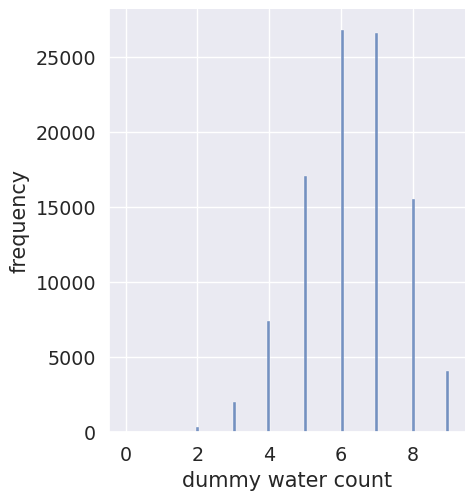

In [26]:
dummy_w = dist.Binomial(total_count=9,probs=0.7).sample(torch.Size([int(1e5)]))
ax = sns.displot(x=dummy_w, kde=False)
ax.set(xlabel='dummy water count', ylabel='frequency')

The resulting plot highlights that most of the time the expected observation does not contain water in the true proportion (0.7), which is the nature of observation: one-to-many relationship between data and data-generating process.

**Model checking**

Model checking means ensuring the model fitting worked
correctly and (2) evaluating the adequacy of a model for some purpose. Since Bayesian mod-
els are always generative, able to simulate observations as well as estimate parameters from
observations, once you condition a model on data, you can simulate to examine the model’s
empirical expectations

For now, we need to learn how to combine sampling of simulated observations, as in the
previous section, with sampling parameters from the posterior distribution. We expect to
do better when we use the entire posterior distribution, not just some point estimate derived
from it. Why? Because there is a lot of information about uncertainty in the entire posterior
distribution. We lose this information when we pluck out a single parameter value and then
perform calculations with it. This loss of information leads to overconfidence.
Let’s do some basic model checks, using simulated observations for the globe tossing
model.

- (1) There is _observation uncertainty_. Even if you know _p_ with certainty (non-zero or non-one), you won't know the exact globe toss with certainty.
- (2) There is _uncertainty about p_, this is what the posterior distribution over _p_ embodies. 

If you were to compute the sampling distribution of outcomes at each value of _p_, then you could average all of these prediction distributions together, using the posterior probabilities of each value of _p_, to get a **posterior predictive distribution**.

In [27]:
# simulate predicted observations for p=0.6
w = dist.Binomial(total_count=9,probs=0.6).sample(torch.Size([int(1e4)]))
w

tensor([7., 2., 7.,  ..., 8., 6., 7.])

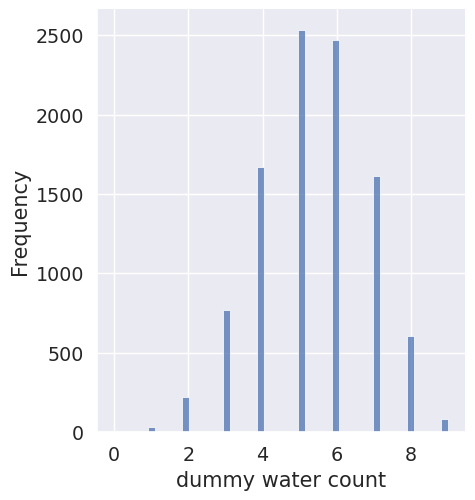

In [28]:
ax = sns.displot(x=w, kde=False)
ax.set(xlabel="dummy water count", ylabel="Frequency");

In [29]:
# propagate parameter uncertainty by replacing 0.6 with samples from the posterior
# (remember) samples = dist.Empirical(p_grid, posterior.log()).sample(torch.Size([int(1e4)]))
w = dist.Binomial(total_count=9, probs=samples).sample()
w

tensor([8., 9., 7.,  ..., 8., 7., 9.])

The symbol samples above is the same list of random samples from the posterior distribu-
tion that you’ve used in previous sections. For each sampled value, a random binomial obser-
vation is generated. Since the sampled values appear in proportion to their posterior proba-
bilities, the resulting simulated observations are averaged over the posterior. You can manip-
ulate these simulated observations just like you manipulate samples from the posterior—you
can compute intervals and point statistics using the same procedures.

**If you plot these sam-
ples, you’ll see the distribution shown in the right-hand plot in Figure 3.6**

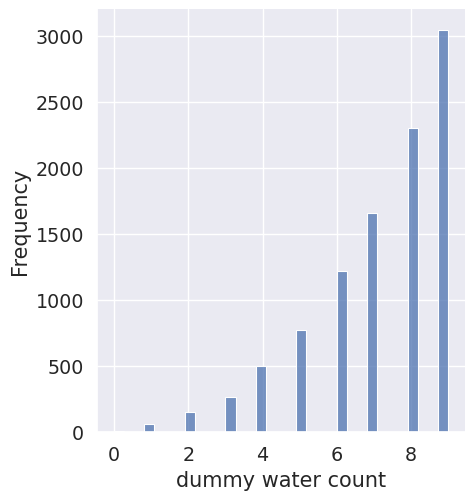

In [30]:
ax = sns.displot(x=w, kde=False)
ax.set(xlabel="dummy water count", ylabel="Frequency");

# 3.4



In [31]:
p_grid = torch.linspace(start=0, end=1, steps=1000)
prior = torch.tensor(1.).repeat(1000)
likelihood = dist.Binomial(total_count=9,
                           probs=p_grid).log_prob(torch.tensor(6.)).exp()
posterior = likelihood * prior
posterior = posterior / posterior.sum()
torch.manual_seed(100)
samples = dist.Empirical(p_grid, posterior.log()).sample(torch.Size([int(1e4)]))

In [32]:
samples

tensor([0.8088, 0.4484, 0.6116,  ..., 0.7568, 0.5325, 0.5636])

**3E1. How much posterior probability lies below p = 0.2?**

In [33]:
sum(samples < 0.2) / 1e4

tensor(0.0010)

Weird, the samples appear to mismatch with what is expected from solutions manual (samples < 0.2 should be 5 and not 10, propagation of error...)

**3E2. How much posterior probability lies above p = 0:8?**

In [34]:
sum(samples > 0.8) / 1e4

tensor(0.1166)

But this one matches again with expectation (solutions manual) that ~11% of posterior probability lies above 0.8

**3E3. How much posterior probability lies between p = 0:2 and p = 0:8?**

In [35]:
sum((samples > 0.2) & (samples < 0.8)) / 1e4

tensor(0.8824)

**3E4. 20% of the posterior probability lies below which value of p?**

In [36]:
stats.quantile(samples, 0.2)

tensor(0.5155)

**3E5. 20% of the posterior probability lies above which value of p?**

In [37]:
stats.quantile(samples, 0.8)

tensor(0.7588)

**3E6. Which values of p contain the narrowest interval equal to 66% of the posterior probability?**

In [38]:
stats.hpdi(samples, prob=0.66)

tensor([0.5155, 0.7858])

**3E7. Which values of p contain 66% of the posterior probability, assuming equal posterior probabil- ity both below and above the interval?**

In [39]:
stats.pi(samples, prob=0.66)

tensor([0.4965, 0.7718])

**3M1. Suppose the globe tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before.**

/tmp/ipykernel_53619/175553375.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(samples)


[Text(0.5, 0, 'proportion water (p)'), Text(0, 0.5, 'density')]

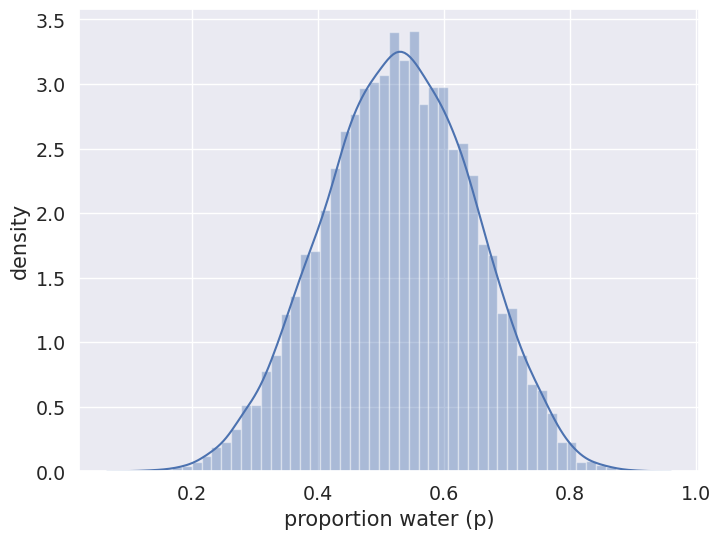

In [40]:
p_grid = torch.linspace(start=0, end=1, steps=1000)
prior = torch.tensor(1.).repeat(1000)
likelihood = dist.Binomial(total_count=15,
                           probs=p_grid).log_prob(torch.tensor(8.)).exp()
posterior = likelihood * prior
posterior = posterior / posterior.sum()
torch.manual_seed(100)
samples = dist.Empirical(p_grid, posterior.log()).sample(torch.Size([int(1e4)]))

ax = sns.distplot(samples)
ax.set(xlabel='proportion water (p)', ylabel='density')

**3M2. Draw 10,000 samples from the grid approximation from above. Then use the samples to calculate the 90% HPDI for p.**

In [41]:
stats.hpdi(samples, prob=0.9)

tensor([0.3363, 0.7237])

**3M3. Construct a posterior predictive check for this model and data. This means simulate the distribution of samples, averaging over the posterior uncertainty in p. What is the probability of observing 8 water in 15 tosses?**

In [42]:
# simulate predicted observations for p=8/15
w = dist.Binomial(total_count=15, probs=samples).sample()

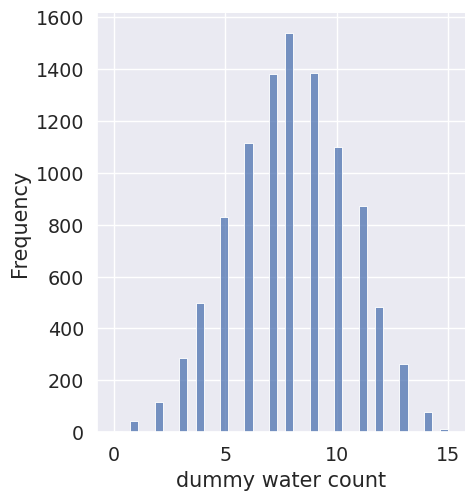

In [43]:
ax = sns.displot(x=w, kde=False)
ax.set(xlabel="dummy water count", ylabel="Frequency");

In [44]:
sum(w == 8)/1e4

tensor(0.1538)

**3M4. Using the posterior distribution constructed from the new (8/15) data, now calculate the prob-
ability of observing 6 water in 9 tosses.**

In [45]:
# simulate predicted observations for p=6/9
w = dist.Binomial(total_count=9, probs=samples).sample()
sum(w==6)/1e4

tensor(0.1731)

**3M5. Start over at 3M1, but now use a prior that is zero below p = 0:5 and a constant above p = 0:5.
This corresponds to prior information that a majority of the Earth’s surface is water. Repeat each
problem above and compare the inferences. What difference does the better prior make? If it helps,
compare inferences (using both priors) to the true value p = 0:7.**

/tmp/ipykernel_53619/309929883.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(samples)


[Text(0.5, 0, 'proportion water (p)'), Text(0, 0.5, 'density'), (0.0, 1.0)]

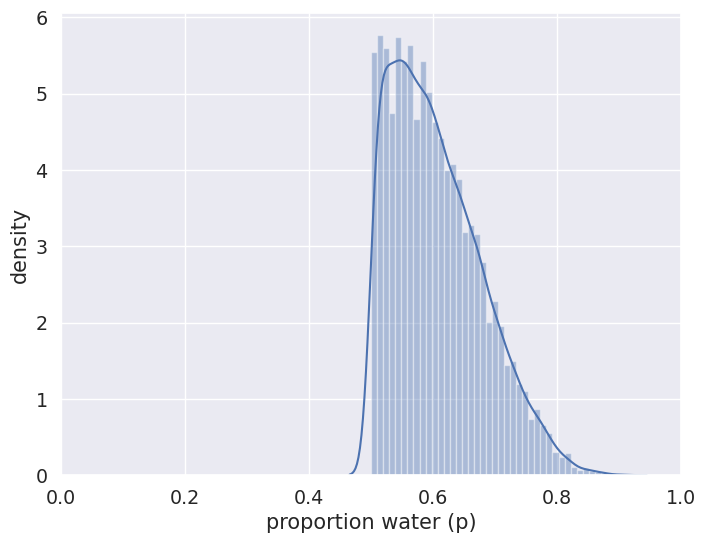

In [46]:
p_grid = torch.linspace(start=0, end=1, steps=1000)
# re-used this line from chapter 2 to make a prior that is 0 below p=0.5 and 1 above p=0.5
prior = torch.where(p_grid < 0.5, torch.tensor(0.), torch.tensor(1.))
likelihood = dist.Binomial(total_count=15,
                           probs=p_grid).log_prob(torch.tensor(8.)).exp()
posterior = likelihood * prior
posterior = posterior / posterior.sum()
torch.manual_seed(100)
samples = dist.Empirical(p_grid, posterior.log()).sample(torch.Size([int(1e4)]))

ax = sns.distplot(samples)
ax.set(xlabel='proportion water (p)', ylabel='density', xlim=[0,1])

The prior essentially tells us to ignore all values _p_ below 0.5, and the probability is concentrated in a much more narrow range.

In [47]:
stats.hpdi(samples, prob=0.9)

tensor([0.5005, 0.7097])